In [1]:
from glob import glob
import xarray as xr
import cftime
import nc_time_axis
import numpy as np
import matplotlib.pyplot as plt

## Read the MCM-UA-1-0 data

In [2]:
UA_Omon = '/archive/uda/CMIP6/CMIP/UA/MCM-UA-1-0/historical/r1i1p1f1/Omon'
UA_Ofx = '/archive/uda/CMIP6/CMIP/UA/MCM-UA-1-0/historical/r1i1p1f1/Ofx'
UA_thetao = f'{UA_Omon}/thetao/gn/v20190731'
UA_volcello = f'{UA_Ofx}/volcello/gn/v20190731'
UA_areacello = f'{UA_Ofx}/areacello/gn/v20190731'

In [3]:
filelist = glob(f'{UA_thetao}/*.nc')
filelist1 = glob(f'{UA_volcello}/*.nc')
filelist2 = glob(f'{UA_areacello}/*.nc')

In [4]:
# It seems that if I don't specify chunks as they exist in the netcdf file (ncdump -sh file | grep -i chunk)
# open_mfdataset uses the size of the file as chunk. Big memory problems ensue...
UA_T = xr.open_mfdataset(filelist, chunks={'time': 1, 'lev': 18, 'latitude': 80, 'longitude': 192})
UA_V = xr.open_mfdataset(filelist1, chunks={'lev': 18, 'latitude': 80, 'longitude': 192} )
UA_A = xr.open_mfdataset(filelist2, chunks={'latitude': 80, 'longitude': 192} )

This is the area as provided by model

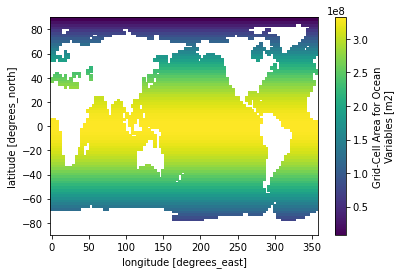

In [5]:
UA_A["areacello"].plot()

Recalculate from scratch:

In [6]:
def compute_area_regular_grid(ds, Rearth=6378e3):
    """ compute the cells area on a regular grid """

    rfac = 2 * np.pi * Rearth / 360

    up = {"bnds": 1}
    down = {"bnds": 0}
    if "time" in ds["lon_bnds"].dims:
        up.update({"time": 0})
        down.update({"time": 0})

    dx1d = rfac * (ds["lon_bnds"].isel(up) - ds["lon_bnds"].isel(down))
    dy1d = rfac * (ds["lat_bnds"].isel(up) - ds["lat_bnds"].isel(down))

    dx2d, dy2d = np.meshgrid(dx1d, dy1d)
    _, lat2d = np.meshgrid(ds["longitude"].values, ds["latitude"].values)

    dx = dx2d * np.cos(2 * np.pi * lat2d / 360)
    dy = dy2d
    area = dx * dy
    return xr.DataArray(area, dims=('latitude', 'longitude'))

In [7]:
area = compute_area_regular_grid(UA_A)

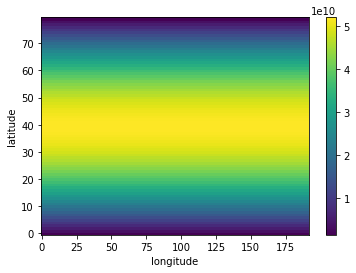

In [8]:
area.plot()

The area provided by the model is 150-190 times smaller than what I computed analytically

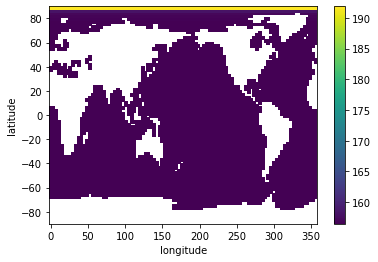

In [10]:
(area/UA_A["areacello"]).plot()

In [11]:
UA_T = UA_T.chunk({'time': 1, 'lev': 18, 'latitude': 80, 'longitude': 192})

In [12]:
UA_V = UA_V.chunk({'lev': 18, 'latitude': 80, 'longitude': 192})

Hence volcello is also too small by orders of magnitude

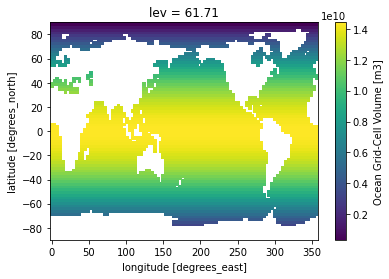

In [13]:
UA_V["volcello"].isel(lev=1).plot()

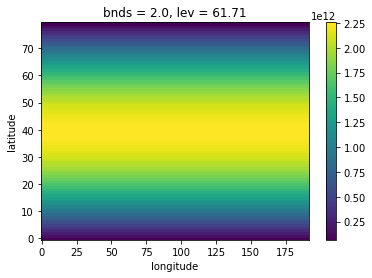

In [14]:
(area * UA_T['lev_bnds'].diff('bnds')).isel(lev=1).plot()

## Compute Ocean Heat Content

In [15]:
OHC_vol_model = 3992 * 1035 * UA_T['thetao'] * UA_V['volcello']

In [16]:
OHC_vol_fix = 3992 * 1035 * UA_T['thetao'] * area * UA_T['lev_bnds'].diff('bnds')

In [17]:
global_OHC_upper700m = OHC_vol_model.sel(lev=slice(0,700)).sum(dim=('lev', 'latitude', 'longitude'))
global_OHC_upper700m_true = OHC_vol_fix.sel(lev=slice(0,700)).sum(dim=('lev', 'latitude', 'longitude'))

In [18]:
global_OHC_upper2000m = OHC_vol_model.sel(lev=slice(0,2000)).sum(dim=('lev', 'latitude', 'longitude'))
global_OHC_upper2000m_true = OHC_vol_fix.sel(lev=slice(0,2000)).sum(dim=('lev', 'latitude', 'longitude'))

In [19]:
global_OHC_2000below = OHC_vol_model.sel(lev=slice(2000,7000)).sum(dim=('lev', 'latitude', 'longitude'))
global_OHC_2000below_true = OHC_vol_fix.sel(lev=slice(2000,7000)).sum(dim=('lev', 'latitude', 'longitude'))

In [20]:
global_OHC = OHC_vol_model.sum(dim=('lev', 'latitude', 'longitude'))
global_OHC_true = OHC_vol_fix.sum(dim=('lev', 'latitude', 'longitude'))

## Go fast with dask cluster

In [21]:
from dask.distributed import Client

client = Client("tcp://140.208.147.156:36703")
client

Client Scheduler: tcp://140.208.147.156:36703 Dashboard: http://140.208.147.156:28787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In dask labextension, create a +NEW cluster. Click the < > widget, scale it to 16 workers and let's go!

In [22]:
%time _ = global_OHC_upper700m.load()
%time _ = global_OHC_upper700m_true.load()

CPU times: user 9.09 s, sys: 52 ms, total: 9.14 s
Wall time: 17.9 s
CPU times: user 9.66 s, sys: 37 ms, total: 9.7 s
Wall time: 15.5 s


In [23]:
%time _ = global_OHC_upper2000m.load()
%time _ = global_OHC_upper2000m_true.load()

CPU times: user 8.93 s, sys: 41 ms, total: 8.97 s
Wall time: 14.6 s
CPU times: user 9.85 s, sys: 47 ms, total: 9.9 s
Wall time: 17.1 s


In [24]:
%time _ = global_OHC_2000below.load()
%time _ = global_OHC_2000below_true.load()

CPU times: user 9.22 s, sys: 42 ms, total: 9.26 s
Wall time: 14.3 s
CPU times: user 9.8 s, sys: 31 ms, total: 9.83 s
Wall time: 15.4 s


In [25]:
%time _ = global_OHC.load()
%time _ = global_OHC_true.load()

CPU times: user 9.13 s, sys: 65 ms, total: 9.19 s
Wall time: 16.1 s
CPU times: user 9.38 s, sys: 45 ms, total: 9.42 s
Wall time: 15.8 s


## Compare with Zanna et al. paper

In [26]:
Zanna = xr.open_dataset('/net2/rnd/Zanna_2018/OHC_GF_1870_2018.nc')
Zanna = Zanna.rename({'time (starting 1870)': 'time'})
Zanna = Zanna.set_coords(['time'])

In [27]:
dates = []
for year in Zanna['time'].values:
    dates.append(cftime.DatetimeNoLeap(year, 7, 16, hour=12))

In [28]:
Zanna['cftime'] = xr.DataArray(np.array(dates), dims='cftime')
Zanna = Zanna.set_coords(['cftime'])

In [29]:
Zanna

<xarray.Dataset>
Dimensions:               (cftime: 149, time: 149)
Coordinates:
  * time                  (time) float64 1.87e+03 1.871e+03 ... 2.018e+03
  * cftime                (cftime) object 1870-07-16 12:00:00 ... 2018-07-16 ...
Data variables:
    OHC_300m              (time) float64 ...
    error_OHC_300         (time) float64 ...
    OHC_700m              (time) float64 ...
    error_OHC_700         (time) float64 ...
    OHC_2000m             (time) float64 ...
    error_OHC_2000        (time) float64 ...
    OHC_below_2000m       (time) float64 ...
    error_OHC_below_2000  (time) float64 ...
    OHC_full_depth        (time) float64 ...
    error_OHC_full_depth  (time) float64 ...

In [30]:
def anom_yearly_avg(da):
    # compute yearly values
    yearly = da.groupby(da.time.dt.year).mean(dim='time')
    # anomamly to 1870 like in Zanna et al.
    anom = yearly - yearly.sel(year=1870)
    return anom

gOHCanom_upper700m_annual = anom_yearly_avg(global_OHC_upper700m)
gOHCanom_upper2000m_annual = anom_yearly_avg(global_OHC_upper2000m)
gOHCanom_2000below_annual = anom_yearly_avg(global_OHC_2000below)
gOHCanom_annual = anom_yearly_avg(global_OHC)

gOHCanom_upper700m_annual_true = anom_yearly_avg(global_OHC_upper700m_true)
gOHCanom_upper2000m_annual_true = anom_yearly_avg(global_OHC_upper2000m_true)
gOHCanom_2000below_annual_true = anom_yearly_avg(global_OHC_2000below_true)
gOHCanom_annual_true = anom_yearly_avg(global_OHC_true)

## Plot the results

### All in one

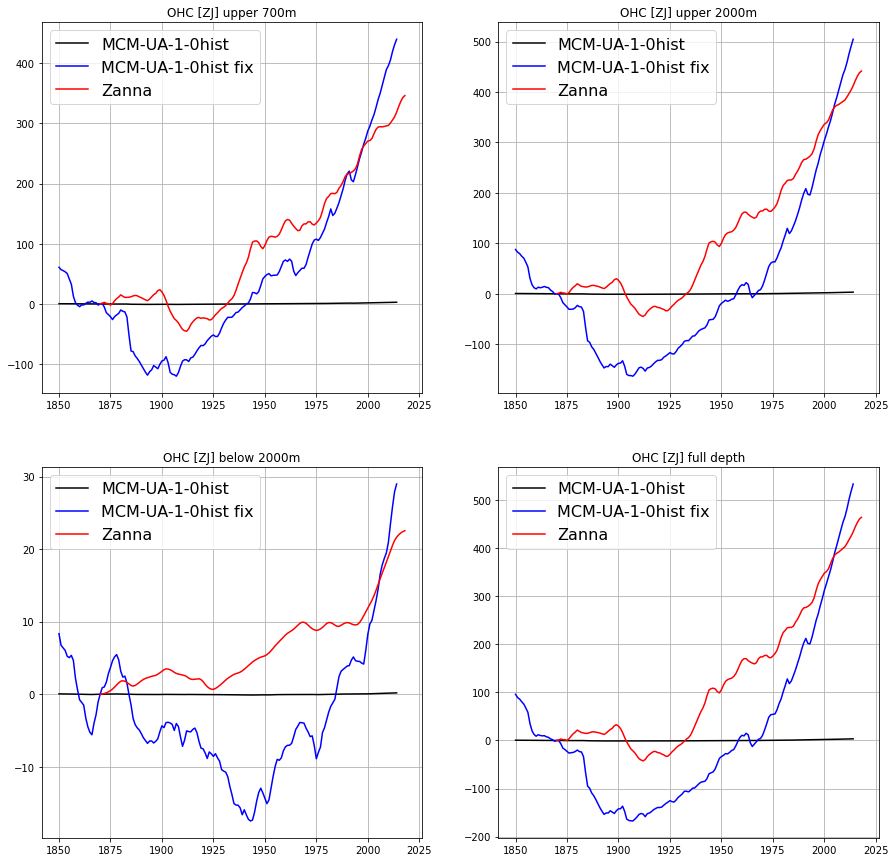

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [31]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=[15,15])

(gOHCanom_upper700m_annual / 1e21).plot(ax=axs[0,0], label='MCM-UA-1-0hist', color='k')
(gOHCanom_upper700m_annual_true / 1e21).plot(ax=axs[0,0], label='MCM-UA-1-0hist fix', color='b')
Zanna['OHC_700m'].plot(ax=axs[0,0], label='Zanna', color='r')
axs[0,0].legend(fontsize=16)
axs[0,0].set_title('OHC [ZJ] upper 700m')
axs[0,0].set_xlabel("")
axs[0,0].set_ylabel("")
axs[0,0].grid()

(gOHCanom_upper2000m_annual / 1e21).plot(ax=axs[0,1], label='MCM-UA-1-0hist', color='k')
(gOHCanom_upper2000m_annual_true / 1e21).plot(ax=axs[0,1], label='MCM-UA-1-0hist fix', color='b')
Zanna['OHC_2000m'].plot(ax=axs[0,1], label='Zanna', color='r')
axs[0,1].legend(fontsize=16)
axs[0,1].set_title('OHC [ZJ] upper 2000m')
axs[0,1].set_xlabel("")
axs[0,1].set_ylabel("")
axs[0,1].grid()

(gOHCanom_2000below_annual / 1e21).plot(ax=axs[1,0], label='MCM-UA-1-0hist', color='k')
(gOHCanom_2000below_annual_true / 1e21).plot(ax=axs[1,0], label='MCM-UA-1-0hist fix', color='b')
Zanna['OHC_below_2000m'].plot(ax=axs[1,0], label='Zanna', color='r')
axs[1,0].legend(fontsize=16)
axs[1,0].set_title('OHC [ZJ] below 2000m')
axs[1,0].set_xlabel("")
axs[1,0].set_ylabel("")
axs[1,0].grid()

(gOHCanom_annual / 1e21).plot(ax=axs[1,1], label='MCM-UA-1-0hist', color='k')
(gOHCanom_annual_true / 1e21).plot(ax=axs[1,1], label='MCM-UA-1-0hist fix', color='b')
Zanna['OHC_full_depth'].plot(ax=axs[1,1], label='Zanna', color='r')
axs[1,1].legend(fontsize=16)
axs[1,1].set_title('OHC [ZJ] full depth')
axs[1,1].set_xlabel("")
axs[1,1].set_ylabel("")
axs[1,1].grid()